<H1>Tinkering with KNN Resgression</H1><br><br>
This notebook stemmed from the end of a Thinkful lesson that prompted me to work on my own KNN regression model. The nature of this sample data set makes this a tricky model to get working well. There is really no way to get it to work well. <br><br>
In the process of tinkering, I learned that the sklearn KNN model's 'distance' weight option weights points by the inverse of the distance to the nearest neighbors (1/distance), so very close neighbors get very heavy weights. The model also allows you to pass in a custom callable weighting function, so I created a simple one that gives weights based solely on rank in terms of distance. Though all models and all parameters perform very poorly, my custom 'ranked' weighting function gives the best results in this example.

In [12]:
import pandas as pd
import numpy as np
import scipy
from sklearn import neighbors
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

music = pd.DataFrame()
music['duration'] = [184, 134, 243, 186, 122, 197, 294, 382, 102, 264, 
                     205, 110, 307, 110, 397, 153, 190, 192, 210, 403,
                     164, 198, 204, 253, 234, 190, 182, 401, 376, 102]
music['loudness'] = [18, 34, 43, 36, 22, 9, 29, 22, 10, 24, 
                     20, 10, 17, 51, 7, 13, 19, 12, 21, 22,
                     16, 18, 4, 23, 34, 19, 14, 11, 37, 42]
music['bpm'] = [ 105, 90, 78, 75, 120, 110, 80, 100, 105, 60,
                  70, 105, 95, 70, 90, 105, 70, 75, 102, 100,
                  100, 95, 90, 80, 90, 80, 100, 105, 70, 65]

#This is the sample data provided by the lesson.

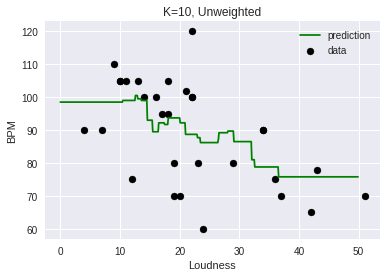

In [13]:
# Build our model.
knn = neighbors.KNeighborsRegressor(n_neighbors=10)
X = pd.DataFrame(music.loudness)
Y = music.bpm
knn.fit(X, Y)

# Set up our prediction line.
T = np.arange(0, 50, 0.1)[:, np.newaxis]

Y_ = knn.predict(T)

plt.scatter(X, Y, c='k', label='data')
plt.plot(T, Y_, c='g', label='prediction')
plt.ylabel('BPM')
plt.xlabel('Loudness')
plt.legend()
plt.title('K={}, Unweighted'.format(knn.n_neighbors))
plt.show()

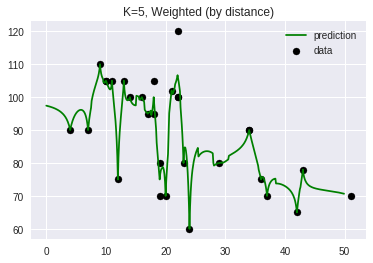

In [14]:
# Run the same model, this time with weights.
knn_w = neighbors.KNeighborsRegressor(n_neighbors=5, weights='distance')
X = pd.DataFrame(music.loudness)
Y = music.bpm
knn_w.fit(X, Y)

# Set up our prediction line.
T = np.arange(0, 50, .1)[:, np.newaxis]

Y_ = knn_w.predict(T)

plt.scatter(X, Y, c='k', label='data')
plt.plot(T, Y_, c='g', label='prediction')
plt.legend()
plt.title('K={}, Weighted (by distance)'.format(knn_w.n_neighbors))
plt.show(); #We see this one severely overfits.

In [15]:
def ranked_weights(dist): #This is my simple rank-based weighting function
    """Returns an array with same dim as dist,
    exploits the fact that dist is ordered by
    rank of distance. Uses index to rank distances.
    """
    lgth, wdth = dist.shape
    wgts = np.zeros(shape=dist.shape)
    for d in range(lgth):
        for i in range(wdth):
            wgts[d][i] = wdth - i 
    return wgts

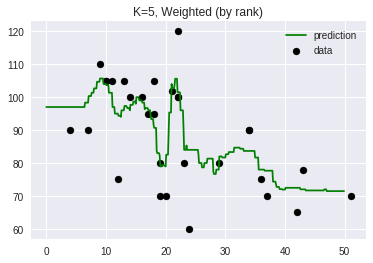

In [16]:
# Run with ranked weights
knn_w = neighbors.KNeighborsRegressor(n_neighbors=5, weights=ranked_weights)
X = pd.DataFrame(music.loudness)
Y = music.bpm
knn_w.fit(X, Y)

T = np.arange(0, 50, .1)[:, np.newaxis]

Y_ = knn_w.predict(T)

plt.scatter(X, Y, c='k', label='data')
plt.plot(T, Y_, c='g', label='prediction')
plt.legend()
plt.title('K={}, Weighted (by rank)'.format(knn_w.n_neighbors))
plt.show(); #We see this one tends to overfit as well, but not so dramatically as the built-in distance function.

In [17]:
#I want to test all values of k for all weighting techniques and see what works best...
cols = ['k', 'weight', 'mean_score', 'score_std']
results = pd.DataFrame(columns=cols)

#unweighted...
i = 1
for k in range(len(music)-6):
    mdl = neighbors.KNeighborsRegressor(n_neighbors=k+1, weights='uniform')
    score = cross_val_score(mdl, X, Y, cv=5)
    new_results = pd.DataFrame(columns=cols)
    new_results.set_value(i, 'k', k+1)
    new_results.set_value(i, 'weight', 'uniform')
    new_results.set_value(i, 'mean_score', score.mean())
    new_results.set_value(i, 'score_std', score.std())
    i += 1
    results = pd.concat([results, new_results])
    
#weighted by distance...
for k in range(len(music)-6):
    mdl = neighbors.KNeighborsRegressor(n_neighbors=k+1, weights='distance')
    score = cross_val_score(mdl, X, Y, cv=5)
    new_results = pd.DataFrame(columns=cols)
    new_results.set_value(i, 'k', k+1)
    new_results.set_value(i, 'weight', 'distance')
    new_results.set_value(i, 'mean_score', score.mean())
    new_results.set_value(i, 'score_std', score.std())
    i += 1
    results = pd.concat([results, new_results])

#weighted by ranked distance...
for k in range(len(music)-6):
    mdl = neighbors.KNeighborsRegressor(n_neighbors=k+1, weights=ranked_weights)
    score = cross_val_score(mdl, X, Y, cv=5)
    new_results = pd.DataFrame(columns=cols)
    new_results.set_value(i, 'k', k+1)
    new_results.set_value(i, 'weight', 'ranked')
    new_results.set_value(i, 'mean_score', score.mean())
    new_results.set_value(i, 'score_std', score.std())
    i += 1
    results = pd.concat([results, new_results])

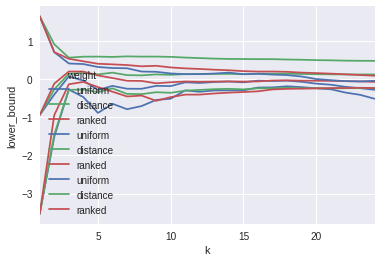

In [18]:
#Plotted with upper and lower bounds based on std of cross validation scores

sns.tsplot(time = 'k', value='mean_score', condition='weight', unit='weight', data=results);
results['upper_bound'] = results.mean_score + results.score_std
results['lower_bound'] = results.mean_score - results.score_std
sns.tsplot(time = 'k', value='upper_bound', condition='weight', unit='weight', data=results);
sns.tsplot(time = 'k', value='lower_bound', condition='weight', unit='weight', data=results);
#leg = plt.legend() #Wanted to fix funky legend

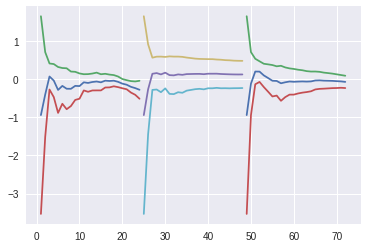

In [19]:
plt.plot(results[results['weight']=='uniform'].mean_score);
plt.plot(results[results['weight']=='uniform'].upper_bound);
plt.plot(results[results['weight']=='uniform'].lower_bound);
plt.plot(results[results['weight']=='distance'].mean_score);
plt.plot(results[results['weight']=='distance'].upper_bound);
plt.plot(results[results['weight']=='distance'].lower_bound);
plt.plot(results[results['weight']=='ranked'].mean_score);
plt.plot(results[results['weight']=='ranked'].upper_bound);
plt.plot(results[results['weight']=='ranked'].lower_bound); #Plotted like this, we can compare better.
#Looks like the standard distance weighting performs marginally better

In [20]:
results.loc[results.mean_score.idxmax()]

k                     3
weight           ranked
mean_score     0.197387
score_std      0.333859
upper_bound    0.531246
lower_bound   -0.136473
Name: 51, dtype: object

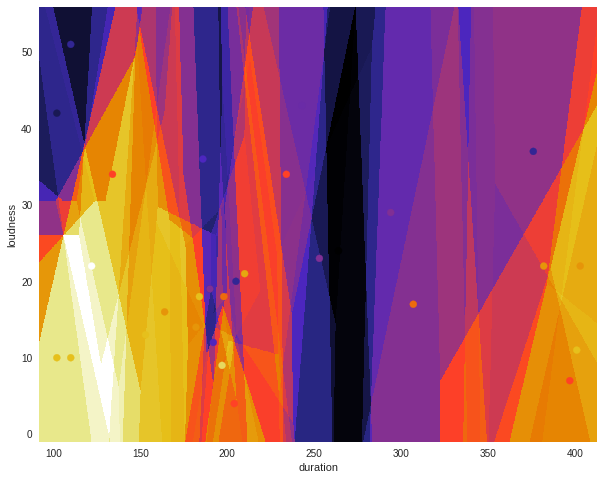

In [21]:
#Use a heatmap to visualize our model.
knn_2d = neighbors.KNeighborsRegressor(n_neighbors=3, weights=ranked_weights)
X = music[['duration', 'loudness']]
Y = music.bpm
knn_2d.fit(X, Y)

dur = music.duration
loud = music.loudness
bpm = music.bpm

h = .1
xx, yy = np.meshgrid(
    np.arange(dur.min()-10, dur.max()+10, h),
    np.arange(loud.min()-5, loud.max()+5, h)
)

Z = knn_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

#handles = (Rectangle((0,0), 1, 1, color=0), Rectangle((0,0), 1, 1, color=.5), Rectangle((0,0), 1, 1, color=1))

plt.figure(1, figsize=(10,8))
plt.set_cmap('CMRmap')
plt.pcolormesh(xx, yy, Z)

plt.scatter(x=dur, y=loud, c=bpm);
plt.xlabel('duration');
plt.ylabel('loudness'); #We can see that this model overfits our data. There's no winning with this sample set.